Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

In [3]:
from copy import deepcopy

In [4]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

# Load Data

In [5]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataLabeled\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('timestamp').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [6]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [7]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Reinforce

In [8]:
from modeling.rl.enviroment import ExchangeEnv
from modeling.rl.estimator import PerceptronPolicyEstimator, PerceptronValueEstimator

cols = ['close', 'timestamp', 'high', 'low', 'open', 'quoteVolume', 'volume']

env = ExchangeEnv(
    data=usdtBtcTrain[cols],
    priceCol='close',
    contractPair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epochLen=1440,
    buyAmount=100
)

In [9]:
def getState(envState):
    return np.array([envState])

In [10]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = getState(env.reset())
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            next_state = getState(next_state)
            # Keep track of the transition
            episode.append(Transition(state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats

In [11]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()


# ---- START -----


# tf.reset_default_graph()

# global_step = tf.Variable(0, name="global_step", trainable=False)
# policy_estimator = PerceptronPolicyEstimator(env.observation_space.n, env.action_space.n)
# value_estimator = PerceptronValueEstimator(env.observation_space.n)

policy_estimator = DummyPolicyEstimator()
value_estimator = DummyValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats = reinforce(env, policy_estimator, value_estimator, 10, discount_factor=1.0)
    
# ---- END ----

pr.disable()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 1438 @ Episode 10/10 (0.0)

In [12]:
s = io.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         11337429 function calls (11337407 primitive calls) in 13.960 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 10375190    6.033    0.000    6.033    0.000 <ipython-input-10-47c979022ca3>:57(<genexpr>)
    14390    3.100    0.000    9.133    0.001 {built-in method builtins.sum}
    28796    2.398    0.000    2.548    0.000 C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py:180(schedule)
    14390    0.695    0.000    0.735    0.000 {method 'choice' of 'mtrand.RandomState' objects}
        1    0.369    0.369   13.677   13.677 <ipython-input-10-47c979022ca3>:1(reinforce)
     2152    0.144    0.000    0.144    0.000 {built-in method nt.stat}
    14390    0.129    0.000    2.853    0.000 {built-in method builtins.print}
    28782    0.124    0.000    2.724    0.000 C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py:342(write)
    14400    0.112    0.000    0.112    0.000 {built-in method nu

In [13]:
def filterEmpty(ll):
    return list(filter(lambda x: len(x)!=0, ll))

def statsToPandas(stats):
    lines = filterEmpty(stats.getvalue().split('\n'))
    cols = filterEmpty(lines[2].split(' '))
    rows = [filterEmpty(l.split(' ')) for l in lines[3:]]
    rows = [l[:5] + [''.join(l[5:])] for l in rows]
    df = pd.DataFrame(rows, columns=cols)
    return df

In [14]:
df = statsToPandas(s)
kryplCalls = df[df['filename:lineno(function)'].str.contains('krypl-project')]
kryplCalls['file'] = kryplCalls['filename:lineno(function)'].apply(lambda x: x.replace('D:\\Gitprojekty\\krypl-project\\', ''))\
    .apply(lambda x: x.replace('D:\\GitProjects\\krypl-project\\', ''))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
kryplCalls.sort_values('tottime', ascending=False)

,ncalls,tottime,percall,cumtime,percall,filename:lineno(function),file
11,14390,0.064,0.000,0.273,0.000,D:\GitProjects\krypl-project\modeling\rl\envir...,modeling\rl\enviroment.py:70(step)
12,14400,0.061,0.000,0.070,0.000,D:\GitProjects\krypl-project\trading\dataManag...,trading\dataManager.py:16(tick)
17,14400,0.027,0.000,0.097,0.000,D:\GitProjects\krypl-project\modeling\rl\envir...,modeling\rl\enviroment.py:44(_getObservation)
21,2910,0.020,0.000,0.062,0.000,D:\GitProjects\krypl-project\trading\exchange....,trading\exchange.py:32(sell)
31,2910,0.010,0.000,0.014,0.000,D:\GitProjects\krypl-project\modeling\rl\envir...,modeling\rl\enviroment.py:64(_reward)
32,14390,0.009,0.000,0.009,0.000,D:\GitProjects\krypl-project\modeling\rl\envir...,modeling\rl\enviroment.py:61(_isDone)
34,14400,0.009,0.000,0.009,0.000,D:\GitProjects\krypl-project\trading\dataManag...,trading\dataManager.py:26(has_tick)
36,4348,0.008,0.000,0.010,0.000,D:\GitProjects\krypl-project\trading\money\tra...,trading\money\transaction.py:36(subtracted_con...
40,1438,0.007,0.000,0.024,0.000,D:\GitProjects\krypl-project\trading\exchange....,trading\exchange.py:23(buy)
41,13078,0.007,0.000,0.011,0.000,D:\GitProjects\krypl-project\trading\exchange....,trading\exchange.py:42(balance)


In [16]:
stats

Stats(episode_lengths=array([ 1438.,  1438.,  1438.,  1438.,  1438.,  1438.,  1438.,  1438.,
        1438.,  1438.]), episode_rewards=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

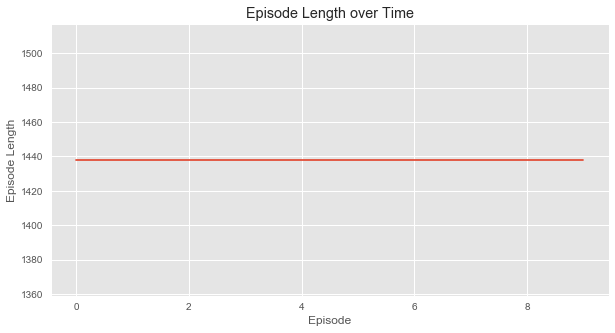

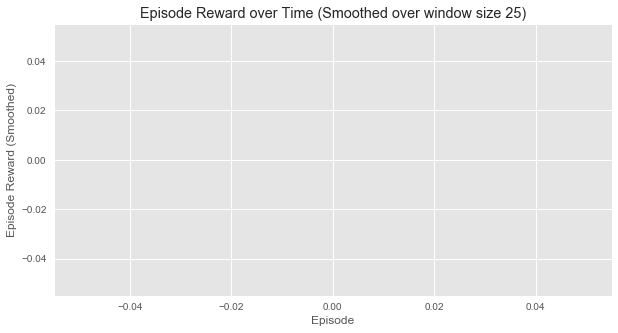

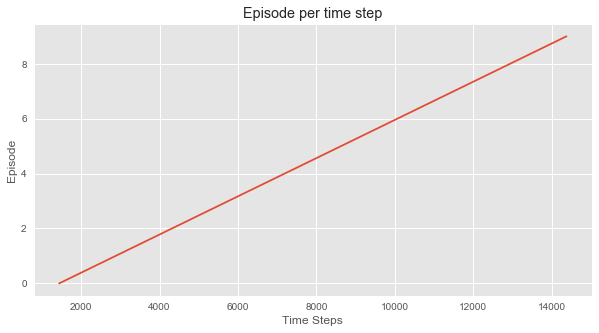

(<matplotlib.figure.Figure at 0x21ea2d19e80>,
 <matplotlib.figure.Figure at 0x21ea2d55668>)

In [17]:
plot_episode_stats(stats, smoothing_window=25)